In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

import sys,os,os.path
sys.path.append("../../../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range, shift_to_bin_centers, binedges_from_bincenters

from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction

from invisible_cities.types.symbols import CutType

from invisible_cities.cities.beersheba          import create_deconvolution_df

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from invisible_cities.types.symbols import CutType


from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve

from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod
from IC.invisible_cities.reco.deconv_functions import deconvolution_input

import IC.invisible_cities.io.mcinfo_io as mcio

from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from tqdm import tqdm
import time

In [68]:
print(binedges_from_bincenters)

<function binedges_from_bincenters at 0x7771fc141b80>


In [69]:
# plot hits
def plot_hits(hits, event = None):
    pitch = 15.55
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()

    axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.000001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.000001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.000001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    if event is None:
        fig.suptitle('Hits', fontsize=30)
    else:
        fig.suptitle(f'Hits: evt {event}', fontsize = 30)
    #plt.savefig(f'plots/hits_{evt}.pdf')
    plt.show(fig)


### load in sophronia q

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
28970,1127289,1.742950e+09,0,147.268254,84.815097,1,-343.675,-185.975,0.0,0.0,626.325625,5.457119,3.347841,-1.0,0.000018,-1,-1.0
28971,1127289,1.742950e+09,0,147.268254,84.815097,1,-343.675,184.225,0.0,0.0,626.325625,9.765893,5.991194,-1.0,0.000032,-1,-1.0
28972,1127289,1.742950e+09,0,147.268254,84.815097,1,-265.925,168.675,0.0,0.0,626.325625,5.613680,3.443889,-1.0,0.000018,-1,-1.0
28973,1127289,1.742950e+09,0,147.268254,84.815097,1,-189.175,152.625,0.0,0.0,626.325625,5.255363,3.224068,-1.0,0.000016,-1,-1.0
28974,1127289,1.742950e+09,0,147.268254,84.815097,1,-34.675,-386.625,0.0,0.0,626.325625,5.230516,3.208825,-1.0,0.000017,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30568968,967777,1.742948e+09,0,40.029658,-169.915785,1,-126.975,-309.875,0.0,0.0,609.824750,5.649685,6.021073,-1.0,0.000032,-1,-1.0
30568969,967777,1.742948e+09,0,40.029658,-169.915785,1,-34.675,-263.225,0.0,0.0,609.824750,6.475501,6.901175,-1.0,0.000035,-1,-1.0
30568970,967777,1.742948e+09,0,40.029658,-169.915785,1,42.075,430.525,0.0,0.0,609.824750,6.036242,6.433040,-1.0,0.000037,-1,-1.0
30568971,967777,1.742948e+09,0,40.029658,-169.915785,1,396.725,168.675,0.0,0.0,609.824750,5.916093,6.304994,-1.0,0.000035,-1,-1.0


Events:
[1127289  716942  904297 ... 1195431 1159871  967777]


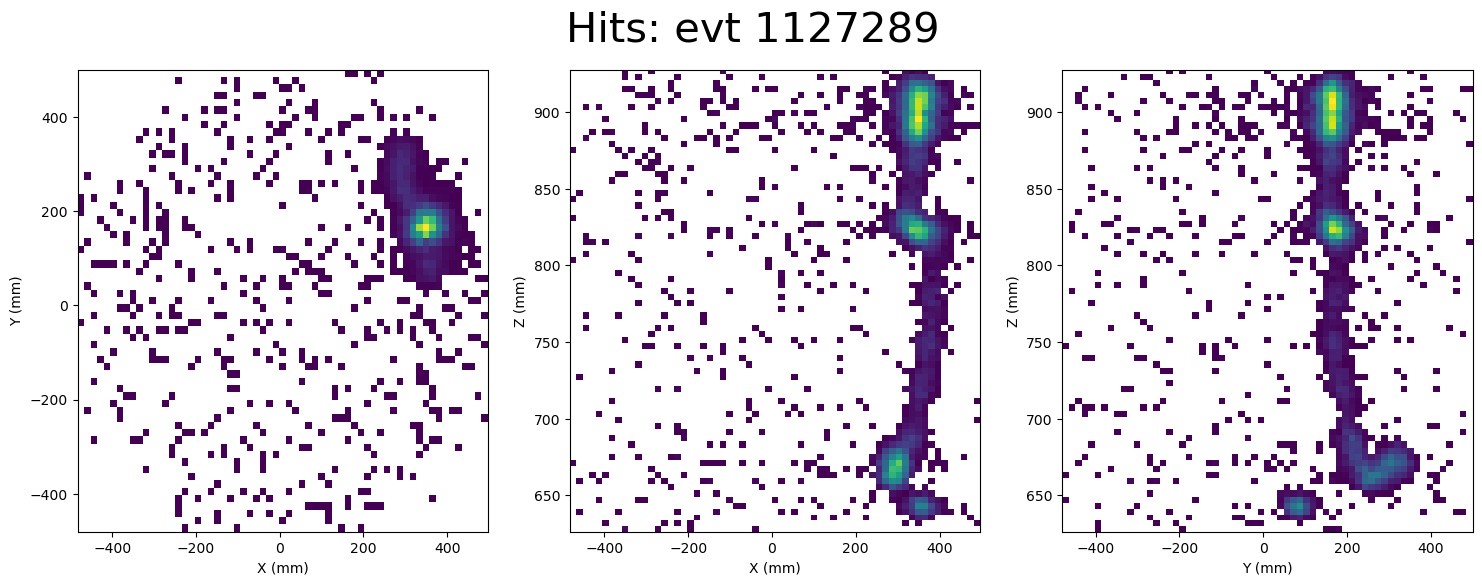

In [70]:
folder_path = 'files/15107_energy_split/'
corr_DES = pd.read_hdf(folder_path + 'corr_DES.h5', 'RECO/Events')
display(corr_DES)
print(f'Events:\n{corr_DES.event.unique()}')
event = corr_DES[corr_DES.event == corr_DES.event.unique()[0]]
plot_hits(event, corr_DES.event.unique()[0])

### look at old method for removing spurious hits

In [71]:
q_cut = 6
drop_dist = [16, 16]

cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])


Q CUT 6 PES


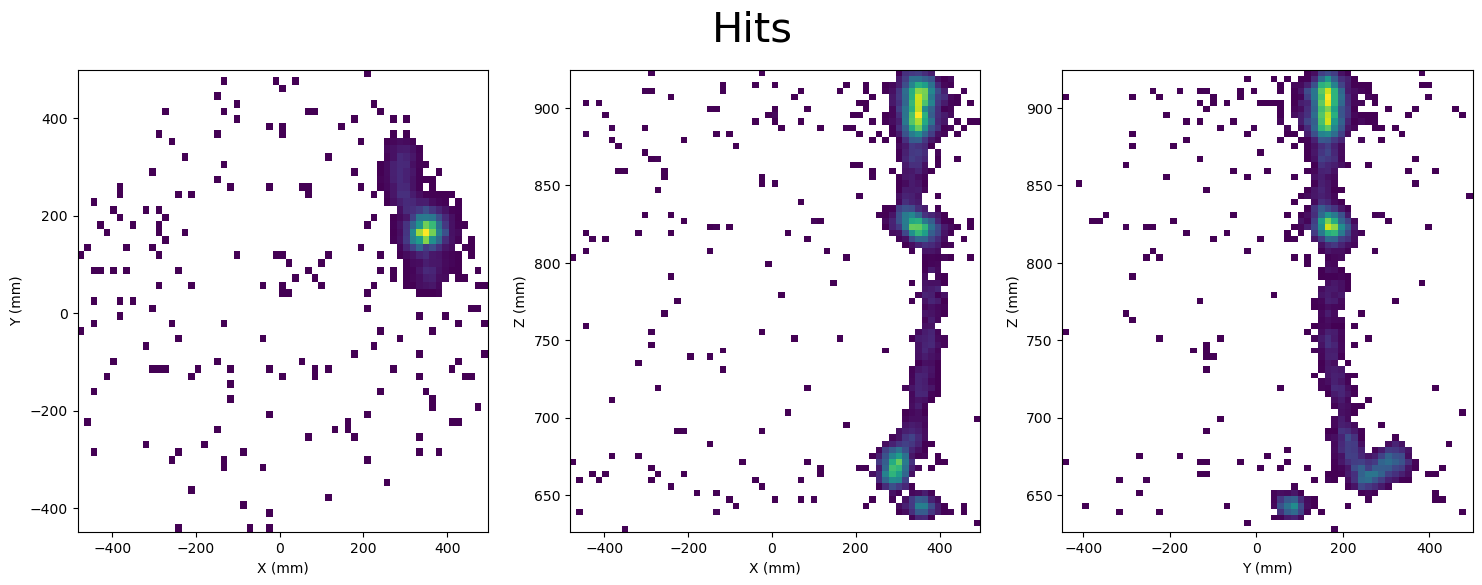

DROP ISOLATED SENSORS
Time taken: 0.028512 seconds


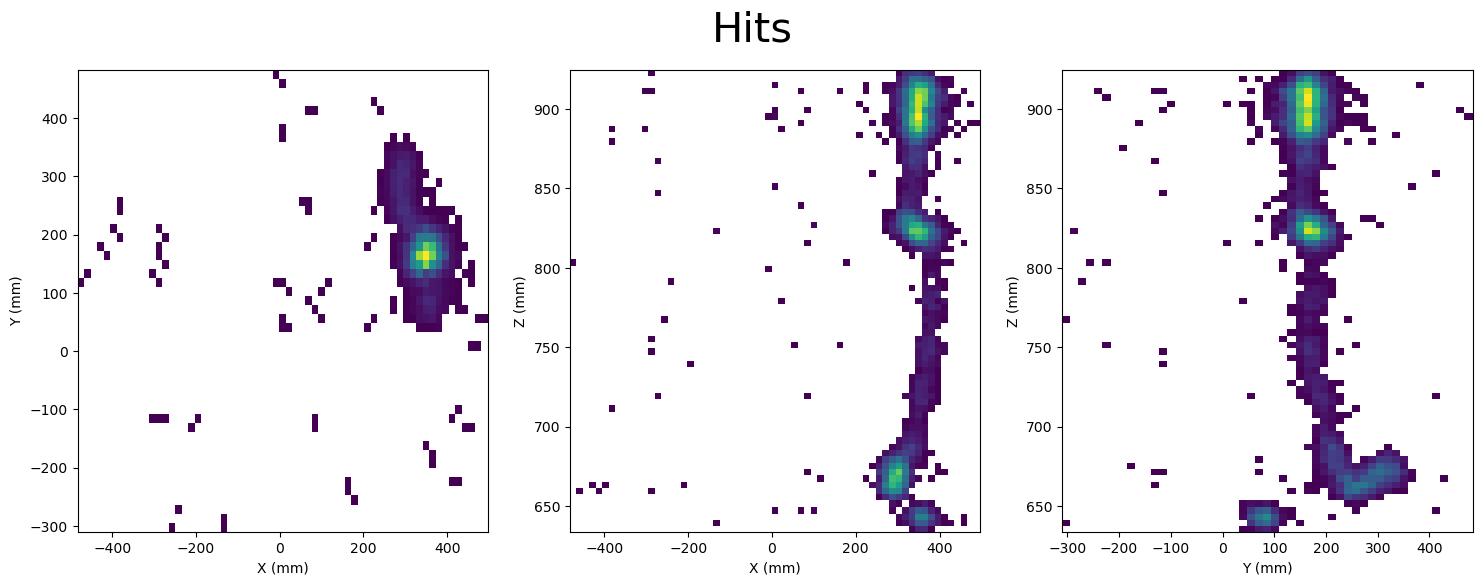

In [106]:
# look at each step
print(f'Q CUT {q_cut} PES')
hits_cut = cut_sensors(event)
plot_hits(hits_cut)
print(f'DROP ISOLATED SENSORS')
start = time.perf_counter()
hits_drop = drop_sensors(hits_cut)
end = time.perf_counter()
print(f'Time taken: {end - start:.6f} seconds')
plot_hits(hits_drop)

### functions for new method

In [73]:
from scipy                  import ndimage as ndi


def collect_component_sizes(im_mask : np.ndarray) -> (np.ndarray, np.ndarray):
    '''
    A function that returns the sizes of different clusters of 1s and 0s within the data
    for removal of satellites.

    This function uses the scipy ndimage library to identify different 'clusters' of 1s within the slice, and
    checks if these clusters are below the size considered for satellite deposits (`satellite_max_size`).
    The method is described in more detail here:
    https://gist.github.com/jwaiton/fd14f43e8da28a49c9c49d43eb00f53f

    Parameters
    ----------
    im_mask : 2D boolean array describing the regions of energy in deconvolution slice

    Returns
    -------
    labels          : 2D array equivalent to im_mask with each region labelled 0, 1, 2, etc
    component_sizes : Array of the length of each component size
    '''
    # label deposits within the array
    # hardcoded to include diagonals in the grouping stage (2)
    # count the bins of each labelled deposit
    footprint       = ndi.generate_binary_structure(im_mask.ndim, 2)
    labels, _       = ndi.label(im_mask, footprint)
    component_sizes = np.bincount(labels.ravel())
    return labels, component_sizes


def convert_to_unitless_array_(data, spacing = 15.55):
    '''
    data = event.loc[:, dimensions].values.T
    '''

    x_min, x_max = data[0].min(), data[0].max()
    y_min, y_max = data[1].min(), data[1].max()
    z_min, z_max = data[2].min(), data[2].max()


    # Compute the size of the grid
    # enforce int, although they should always be int!
    # add a check here in case they're not ints
    x_bins = int(((x_max - x_min) // spacing) + 1)
    y_bins = int(((y_max - y_min) // spacing) + 1)
    z_bins = int(((z_max - z_min) // spacing) + 1)


    # Initialize empty grid of zeros
    grid = np.zeros((x_bins, y_bins, z_bins), dtype = int)

    # Compute indices in the grid for each point
    x_idx = ((data[0] - x_min) // spacing).astype(int)
    y_idx = ((data[1] - y_min) // spacing).astype(int)
    z_idx = ((data[2] - z_min) // spacing).astype(int)


    # Set corresponding grid positions to 1
    grid[x_idx, y_idx, z_idx] = 1

    return grid


### collect the relevant data

In [74]:
n_dim = 3
dimensions    = np.array  (['X', 'Y', 'Z'][:n_dim])
data = event.loc[:, dimensions].values.T
print(data)
print(data.shape)
for i, dim in enumerate(data):
    print('='*20)
    print(dimensions[i])
    print(dim)
    print('Unique differences between dimensions')
    print(np.unique(np.diff(np.unique(dim))))


[[-343.675    -343.675    -265.925    ...  366.625     351.075
   273.325   ]
 [-185.975     184.225     168.675    ...  184.225     198.775
  -185.975   ]
 [ 626.325625  626.325625  626.325625 ...  924.776875  924.776875
   927.6835  ]]
(3, 2679)
X
[-343.675 -343.675 -265.925 ...  366.625  351.075  273.325]
Unique differences between dimensions
[14.55 14.55 14.55 14.55 14.55 15.55 15.55 15.55 15.55 15.55 15.55 15.55]
Y
[-185.975  184.225  168.675 ...  184.225  198.775 -185.975]
Unique differences between dimensions
[ 0.5  14.55 14.55 14.55 14.55 14.55 15.05 15.05 15.05 15.05 15.05 15.05
 15.55 15.55]
Z
[626.325625 626.325625 626.325625 ... 924.776875 924.776875 927.6835  ]
Unique differences between dimensions
[2.906625 3.6895   3.709375 3.71825  3.797625 3.80025  3.81575  3.824
 3.827    3.837    3.852625 3.85575  3.857125 3.877875 3.8795   3.880875
 3.886125 3.887625 3.893875 3.9      3.90025  3.9045   3.911    3.91575
 3.91675  3.917375 3.926    3.9275   3.9275   3.92775  3.934875 

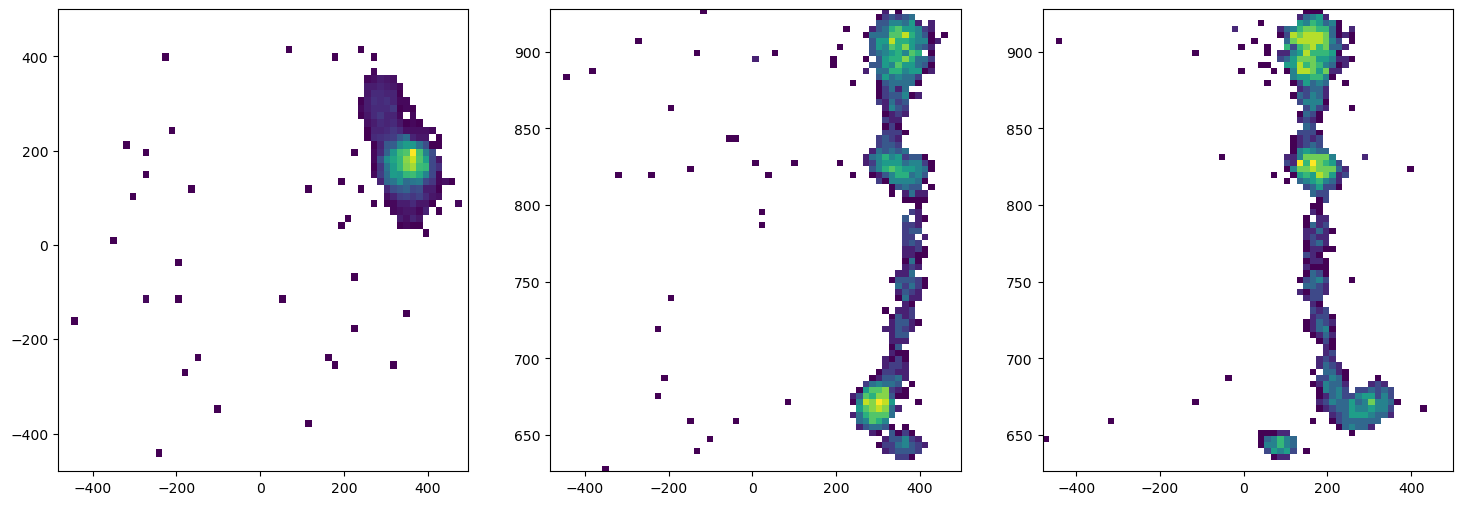

In [75]:
# try and plot these now
pitch = 15.55
xx = np.arange(data[0].min(), data[0].max() + pitch, pitch)
yy = np.arange(data[1].min(), data[1].max() + pitch, pitch)
zz = np.unique(data[2])


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist2d(data[0], data[1], bins = [xx,yy], cmin = 2)
axes[1].hist2d(data[0], data[2], bins = [xx,zz], cmin = 2)
axes[2].hist2d(data[1], data[2], bins = [yy,zz], cmin = 2)
plt.show(fig)

### attempting to implement dbscan

In [76]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [77]:
def drop_sparse_clusters_per_z(df, eps, min_units=3, clusters_id = False):
    result_frames = []

    for z_val, layer_df in df.groupby("Z"):
        coords = layer_df[["X", "Y"]].values

        if len(coords) < min_units:
            continue  # Not enough points to form a cluster

        db = DBSCAN(eps=eps, min_samples=min_units).fit(coords)
        labels = db.labels_

        # Keep only clustered points (label != -1)
        mask = labels != -1
        clustered_df = layer_df.loc[mask].copy()

        # Optional: include cluster labels
        if clusters_id:
            clustered_df["cluster_id"] = labels[mask]

        result_frames.append(clustered_df)

    return pd.concat(result_frames, ignore_index=True)

Time taken: 0.158868 seconds


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep,NormQ
0,1127289,1.742950e+09,0,147.268254,84.815097,1,366.625,60.825,0.0,0.0,633.733375,11.992411,172.945247,-1.0,0.000941,-1,-1.0,NaN
1,1127289,1.742950e+09,0,147.268254,84.815097,1,335.525,90.925,0.0,0.0,633.733375,10.660346,153.735244,-1.0,0.000795,-1,-1.0,NaN
2,1127289,1.742950e+09,0,147.268254,84.815097,1,351.075,75.375,0.0,0.0,633.733375,15.977192,230.410672,-1.0,0.001229,-1,-1.0,NaN
3,1127289,1.742950e+09,0,147.268254,84.815097,1,351.075,90.925,0.0,0.0,633.733375,26.595436,383.538755,-1.0,0.002031,-1,-1.0,NaN
4,1127289,1.742950e+09,0,147.268254,84.815097,1,351.075,106.475,0.0,0.0,633.733375,7.582779,109.352957,-1.0,0.000570,-1,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,1127289,1.742950e+09,0,147.268254,84.815097,1,381.175,184.225,0.0,0.0,920.924250,8.259615,57.602322,-1.0,0.000328,-1,-1.0,NaN
2009,1127289,1.742950e+09,0,147.268254,84.815097,1,319.975,153.125,0.0,0.0,924.776875,6.528119,43.102847,-1.0,0.000220,-1,-1.0,NaN
2010,1127289,1.742950e+09,0,147.268254,84.815097,1,319.975,168.675,0.0,0.0,924.776875,10.175396,67.184519,-1.0,0.000346,-1,-1.0,NaN
2011,1127289,1.742950e+09,0,147.268254,84.815097,1,319.975,184.225,0.0,0.0,924.776875,6.227802,41.119962,-1.0,0.000216,-1,-1.0,NaN


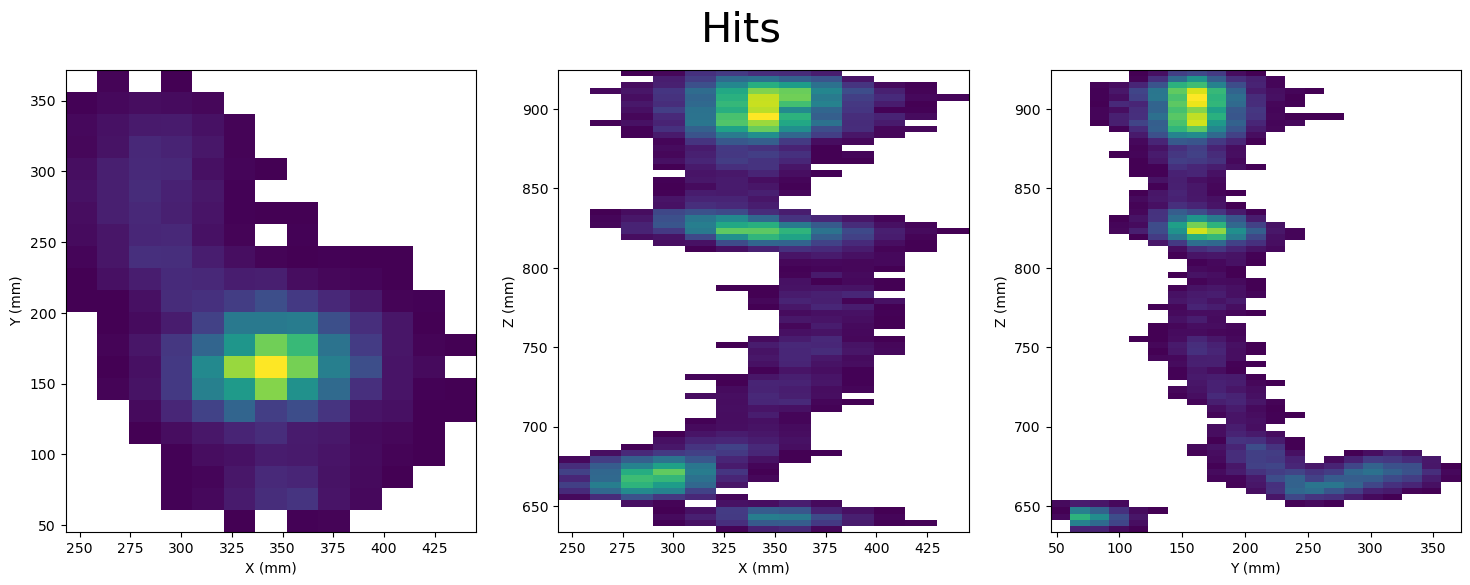

In [105]:
start = time.perf_counter()
event_z_dropped = drop_sparse_clusters_per_z(event, eps = np.sqrt(pitch**2 + pitch ** 2), min_units = 3)
end   = time.perf_counter()
print(f'Time taken: {end - start:.6f} seconds')
display(event_z_dropped)
plot_hits(event_z_dropped)

### other method

In [139]:
def convert_to_unitless_array_(data, dim = 2, spacing = 15.55):
    '''
    data = event.loc[:, dimensions].values.T
    dim -> dimensions (x,y or x,y,z)
    spacing -> pitch
    '''
    bins   = []
    ids    = []
    minmax = []
    for i in range(0, dim):
        _min, _max = data[i].min(), data[i].max()
        _bins      = (((_max - _min) // spacing) + 1).astype(int)
        _ids       = ((data[i] - _min) // spacing).astype(int)

        bins.append(  _bins)
        ids.append(   _ids)
        minmax.append([_min, _max])
    
    # create empty grid
    grid = np.zeros(tuple(bins), dtype = int)
    # unpack regardless of dimensions
    coords = list([np.array(indices) for indices in ids])
    # fill with the data
    grid[tuple(coords)] = 1


    return grid, np.array(minmax)

def convert_to_unitbased_array_(grid, minmax, dim = 2, spacing = 15.55):
    '''
    convert back into event.loc[:, dimensions].values.T
    minmax is the minimum and maximum for each point shape:
    [[xmin, xmax], [ymin, ymax], [zmin, zmax]]
    '''
    
    occupied = np.argwhere(grid == 1)

    # recover initial coordinates with minima from each dimension
    points = occupied * spacing + minmax[:,0]

    return points


In [146]:
n_dim = 2
dimensions    = np.array  (['X', 'Y', 'Z'][:n_dim])
# test that you can get back what you put in
for z_val, layer_df in event.groupby("Z"):
    data             = layer_df.loc[:, dimensions].values.T
    grid, minmax     = convert_to_unitless_array_(data)
    points           = convert_to_unitbased_array_(grid, minmax)
    print(data)
    print('='*50)
    print(np.diff(data[0])/15.55)
    print(np.diff(data[1])/15.55)
    print('='*50)
    print(points.T)
    break
    #print(np.unique(data) == np.unique(points))


[[-343.675 -343.675 -265.925 -189.175  -34.675]
 [-185.975  184.225  168.675  152.625 -386.625]]
[0.         5.         4.93569132 9.93569132]
[ 23.80707395  -1.          -1.03215434 -34.67845659]
[[-343.675 -343.675 -281.475 -203.725  -48.225]
 [-200.025  173.175  157.625  142.075 -386.625]]


# GRAVEYARD 2

### lets attempt this but with the other method

In [95]:
# cannibilising deconvolution_input
def convert_input( sample_width 
                 , det_grid):

    def convert(data, weight):
       '''
       result passed in as 
       '''

       # create the range over which we bin
       eps = np.finfo(np.float32).eps
       ranges = [ [ coord.min() - 1.5 * sw
                   , coord.max() + 1.5 * sw + eps]
                   for coord, sw in zip(data, sample_width) ]


       # create the bins and histogram accordingly

       # collect centres (based on det_grid) then edges
       bin_centres = [grid[in_range(grid, *rang)] for rang, grid in zip(ranges, det_grid)]
       bin_edges   = [binedges_from_bincenters(bins) for bins in bin_centres]
       
       hs, edges = np.histogramdd(data, bins = bin_edges, normed = False, weights=weight)

       inter_points = np.meshgrid(*(shift_to_bin_centers(edge) for edge in edges), indexing='ij')
       inter_points = tuple      (inter_p.flatten() for inter_p in inter_points)

       return hs, inter_points, edges

    return convert

In [80]:
#display(tuple(event.loc[:, dimensions].values.T))
#print()

In [ ]:

detector_db = 'next100'
run_number = 15107
det_db = DataSiPM(detector_db, run_number)

n_dim = 2

sample_width = [15.55] * n_dim
dimensions    = np.array  (['X', 'Y', 'Z'][:n_dim])
bin_size = np.asarray([1.] * n_dim)
det_grid      = [np.arange(det_db[var].min() + bs/2, det_db[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
                     for var, bs in zip(dimensions, bin_size)]

conversion = convert_input(sample_width, det_grid)

hs, inter_points, edges = conversion(tuple(event.loc[:, dimensions].values.T), event.NormQ.values)
print('=' * 23)
print(hs)
print(type(hs))
print(hs.shape)
print('=' * 23)
print(inter_points)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(972, 972)
(array([-481.875, -481.875, -481.875, ...,  488.625,  488.625,  488.625]), array([-479.175, -478.425, -477.425, ...,  489.575,  490.575,  491.325]))


/home/e78368jw/anaconda3/envs/IC-3.8-2024-06-08/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [96]:
event_fixed = []

event.loc[:, "NormQ"] = np.nan
for peak, hits in event.groupby("npeak"):
            hits.loc[:, "NormQ"] = hits.loc[:, 'Q'] / hits.loc[:, 'Q'].sum()


# so automate this across Z
detector_db = 'next100'
run_number = 15107
det_db = DataSiPM(detector_db, run_number)

n_dim = 2

sample_width = [15.55] * n_dim
dimensions    = np.array  (['X', 'Y', 'Z'][:n_dim])
bin_size = np.asarray([1.] * n_dim)
det_grid      = [np.arange(det_db[var].min() + bs/2, det_db[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
                     for var, bs in zip(dimensions, bin_size)]

conversion = convert_input(sample_width, det_grid)

for z_val, layer_df in event.groupby("Z"):
    # convert to usable shape
    hs, inter_points, edges = conversion(tuple(event.loc[:, dimensions].values.T), event.NormQ.values)
    mask = (hs > 0).astype(int)

    grid_labels, grid_components = collect_component_sizes(mask)
    # apply a mask of any groups below 10
    too_small = grid_components < 10
    too_small_mask = too_small[grid_labels]

    mask[too_small_mask] = 0
    hs[mask] = 0
    cut = CutType.abs
    event_fixed.append(create_deconvolution_df(layer_df, hs.flatten(), inter_points, cut, 0, n_dim))

event_concat = pd.concat(event_fixed)

/home/e78368jw/anaconda3/envs/IC-3.8-2024-06-08/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [97]:
display(event_concat)

,event,npeak,X,Y,Z,E


### you now have an output that you can create a mask with (hs)

In [ ]:
print(np.sum(hs))
print(np.max(hs))

2661.0
53.0


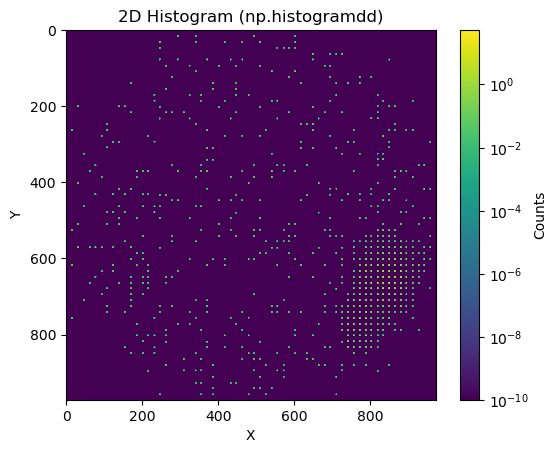

In [ ]:
from matplotlib.colors import LogNorm
H = hs
H[H == 0] = 1e-10
plt.imshow(H.T, norm = LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram (np.histogramdd)')
plt.show()

In [ ]:
def convert_to_unitless_array_(data, dim = 3, spacing = 15.55):
    '''
    data = event.loc[:, dimensions].values.T
    dim -> dimensions (x,y or x,y,z)
    spacing -> pitch
    '''
    bins = []
    ids  = []
    for i in range(0, dim):
        _min, _max = data[i]
        _bins      = (((_max - _min) // spacing) + 1).astype(int)
        _ids       = ((data[i] - _min) // spacing).astype(int)

        bins.append(_bins)
        ids.append(_ids)
    
    # create empty grid
    grid = np.zeros(tuple(bins), dtype = int)

    # unpack regardless of dimensions
    coords = list([np.array(indices) for indices in ids])
    # fill with the data
    grid[tuple(coords)] = 1


    return grid


In [ ]:
dimensions = 2
for z_val, layer_df in event.groupby("Z"):
    # shape data as needed
    z_data = layer_df.loc[:, dimensions].values.T
    unitless_data = convert_to_unitless_array_(z_data, dim = dimensions).T

    # collect the relevant sections
    grid_labels, grid_components = collect_component_sizes(unitless_data)

    # apply a mask of any groups below 10
    too_small = grid_components < 10
    too_small_mask = too_small[grid_labels]
    grid_data[too_small_mask] = 0

# graveyard

In [ ]:
# distance between points should be pitch 
dist = np.sqrt(pitch**2 + pitch ** 2)

X = np.array(list([x,y,z] for (x,y,z) in zip(data[0], data[1], data[2])))
print(X)

db = DBSCAN(eps = dist, min_samples = 50).fit(X)
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

[[-343.675    -185.975     626.325625]
 [-343.675     184.225     626.325625]
 [-265.925     168.675     626.325625]
 ...
 [ 366.625     184.225     924.776875]
 [ 351.075     198.775     924.776875]
 [ 273.325    -185.975     927.6835  ]]
Estimated number of clusters: 2
Estimated number of noise points: 2457


In [ ]:
print(X)
print(n_clusters_)
print(labels)

[[-343.675    -185.975     626.325625]
 [-343.675     184.225     626.325625]
 [-265.925     168.675     626.325625]
 ...
 [ 366.625     184.225     924.776875]
 [ 351.075     198.775     924.776875]
 [ 273.325    -185.975     927.6835  ]]
2
[-1 -1 -1 ...  1 -1 -1]


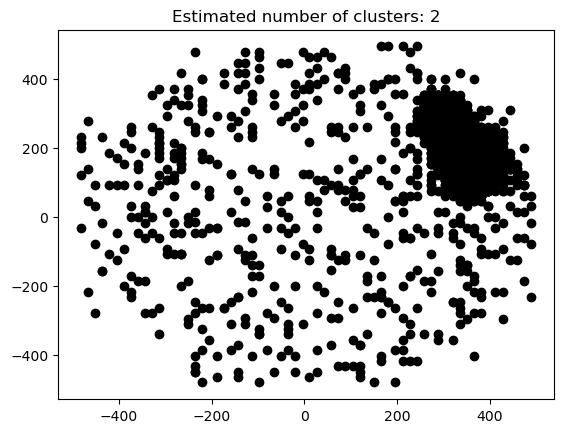

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


In [ ]:
signal_mask = labels != -1
X_signal = X[signal_mask]
labels_signal = labels[signal_mask]

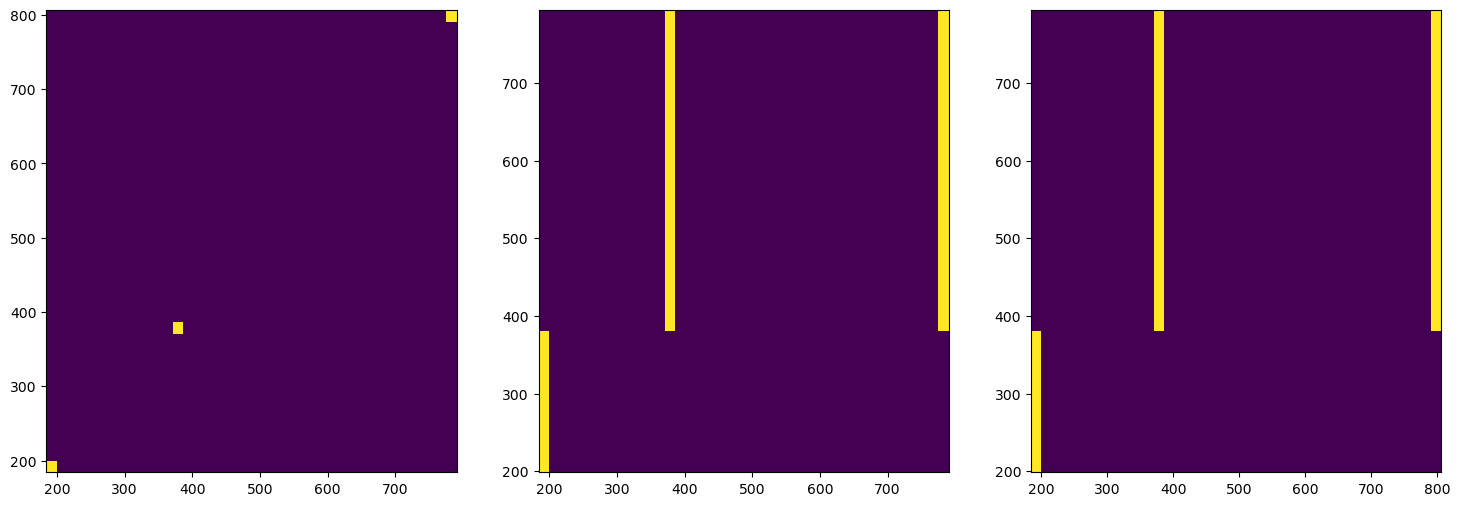

In [ ]:
q = X_signal

# try and plot these now
pitch = 15.55
xx = np.arange(q[0].min(), q[0].max() + pitch, pitch)
yy = np.arange(q[1].min(), q[1].max() + pitch, pitch)
zz = np.unique(q[2])


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist2d(q[0], q[1], bins = [xx,yy])
axes[1].hist2d(q[0], q[2], bins = [xx,zz])
axes[2].hist2d(q[1], q[2], bins = [yy,zz])
plt.show(fig)

In [ ]:
# reshape again
print(q)

[[381.175    184.225    789.2145  ]
 [381.175    184.225    793.38575 ]
 [381.175    198.775    793.38575 ]
 [366.625    184.225    797.279625]
 [381.175    168.675    797.279625]
 [396.725    184.225    797.279625]
 [366.625    184.225    801.38425 ]
 [366.625    198.775    801.38425 ]
 [381.175    198.775    801.38425 ]
 [366.625    168.675    805.523375]
 [366.625    184.225    805.523375]
 [366.625    198.775    805.523375]
 [381.175    168.675    805.523375]
 [381.175    184.225    805.523375]
 [396.725    184.225    805.523375]
 [381.175    198.775    805.523375]
 [396.725    198.775    805.523375]
 [351.075    184.225    809.709875]
 [366.625    168.675    809.709875]
 [366.625    184.225    809.709875]
 [366.625    198.775    809.709875]
 [381.175    168.675    809.709875]
 [381.175    184.225    809.709875]
 [396.725    168.675    809.709875]
 [396.725    184.225    809.709875]
 [381.175    198.775    809.709875]
 [396.725    198.775    809.709875]
 [351.075    184.225    813.

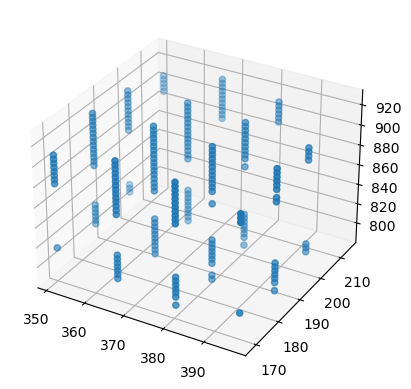

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(q[:, 0], q[:, 1], q[:, 2])